In [73]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [63]:
jobs = generate_job_defs("config.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    for path in paths:
        data = json.load(open(path))
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": int(job.params["epochs"]),
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * job.params["epochs"] * job.params["train_num_samples"]
        }
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
results = pd.DataFrame(results)
results.head()

,model,pretrain_dataset,downstream_dataset,epoch,total_epochs,name,gflops_total,job_id_regexp,cmd,check_interval_secs,...,termination_cmd,dataset,datacomp,train_data,logs,acc1,acc5,mean_per_class_recall,image_retrieval_recall@5,text_retrieval_recall@5
0,ViT-B-32,datacomp,wds/imagenet1k,7,10,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,18918400.0,Job Id:(\d+),sbatch sbatch_scripts/datacomp_ViT-B-32_ep10_l...,600,...,"let last=10-1;grep ""Train Epoch: $last.*100%"" ...",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/...,logs,0.00160,0.00722,0.00164,NaN,NaN
1,ViT-B-32,datacomp,wds/imagenet1k,5,10,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,18918400.0,Job Id:(\d+),sbatch sbatch_scripts/datacomp_ViT-B-32_ep10_l...,600,...,"let last=10-1;grep ""Train Epoch: $last.*100%"" ...",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/...,logs,0.00190,0.00688,0.00182,NaN,NaN
2,ViT-B-32,datacomp,wds/mscoco_captions,9,10,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,18918400.0,Job Id:(\d+),sbatch sbatch_scripts/datacomp_ViT-B-32_ep10_l...,600,...,"let last=10-1;grep ""Train Epoch: $last.*100%"" ...",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/...,logs,NaN,NaN,NaN,0.001239,0.002
3,ViT-B-32,datacomp,wds/mscoco_captions,3,10,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,18918400.0,Job Id:(\d+),sbatch sbatch_scripts/datacomp_ViT-B-32_ep10_l...,600,...,"let last=10-1;grep ""Train Epoch: $last.*100%"" ...",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/...,logs,NaN,NaN,NaN,0.001199,0.001
4,ViT-B-32,datacomp,wds/imagenet1k,4,10,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,18918400.0,Job Id:(\d+),sbatch sbatch_scripts/datacomp_ViT-B-32_ep10_l...,600,...,"let last=10-1;grep ""Train Epoch: $last.*100%"" ...",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/...,logs,0.00148,0.00616,0.00152,NaN,NaN


# Results

In [77]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/imagenet1k'
metric = 'acc1'

d = d[d.downstream_dataset==ds]
d[['model', 'samples_seen_scale', 'downstream_dataset', metric , "lr", "gflops_total", "name", "siglip"]].sort_values(by=metric, ascending=False).round(4)

,model,samples_seen_scale,downstream_dataset,acc1,lr,gflops_total,name,siglip
14,ViT-B-32,1.28M,wds/imagenet1k,0.0015,0.0005,18918400.0,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,True
54,ViT-B-32,1.28M,wds/imagenet1k,0.0015,0.0010,18918400.0,datacomp_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_...,True
34,ViT-B-32,1.28M,wds/imagenet1k,0.0014,0.0005,18918400.0,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,False
74,ViT-B-32,1.28M,wds/imagenet1k,0.0010,0.0010,18918400.0,datacomp_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_...,False


In [ ]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/mscoco_captions'
metric = 'image_retrieval_recall@5'

d = d[d.downstream_dataset==ds]
d[['model', 'samples_seen_scale', 'downstream_dataset', metric , "lr", "gflops_total", "name", "siglip"]].sort_values(by=metric, ascending=False).round(4)

,model,samples_seen_scale,downstream_dataset,image_retrieval_recall@5,lr,gflops_total,name,siglip
29,ViT-B-32,1.28M,wds/mscoco_captions,0.0018,0.0005,18918400.0,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,False
9,ViT-B-32,1.28M,wds/mscoco_captions,0.0014,0.0005,18918400.0,datacomp_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95...,True
49,ViT-B-32,1.28M,wds/mscoco_captions,0.0012,0.0010,18918400.0,datacomp_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_...,True
69,ViT-B-32,1.28M,wds/mscoco_captions,0.0010,0.0010,18918400.0,datacomp_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_...,False


# Downstream Task Learning curves

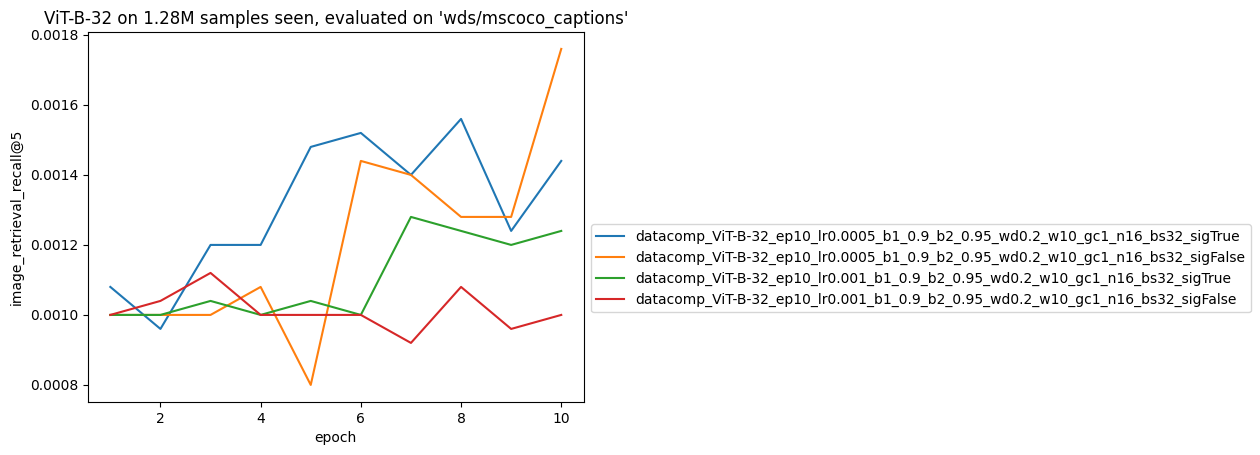

In [52]:
d =results

model = "ViT-B-32"
samples_seen = "1.28M"
#samples_seen = "12.80B"
#samples_seen = "1.28B"

#ds = 'wds/imagenet1k'
#metric = 'acc1'

ds = "wds/mscoco_captions"
metric = 'image_retrieval_recall@5'

d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
sns.lineplot(x="epoch", y=metric, data=d, hue="name")
#d = d.sort_values(by='epoch')
#d.plot(x='epoch', y=metric)
plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

# Scaling curve

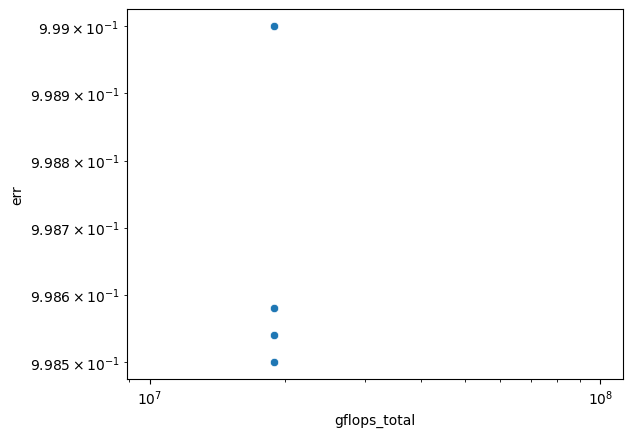

In [72]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")